In [40]:
import os
import numpy as np 
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [41]:
os.chdir('/kaggle/input/BloodPressureDataset')

# ECG Features

An ECG (electrocardiogram) signal is composed of several key components inlcuding P wave, PR interval, QRS complex, ST segment and T wave. 
Distinctive spikes within the QRS complex are known as R-peaks and represent ventricular depolarization. 
The RR interval, measured as the time between consecutive R-peaks, is usually used for heart rate calculation. 
Furthermore, the variability in RR intervals, known as heart rate variability (HRV), is associated with adaptability and health of cardiovascular hsystem. 


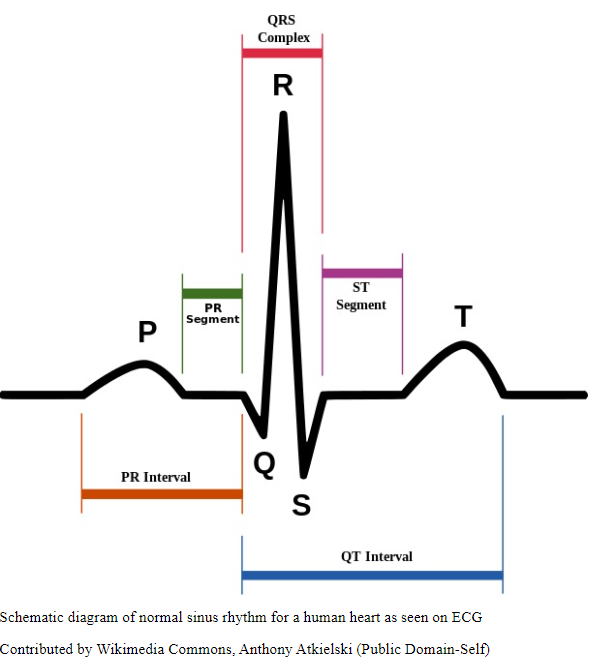

In [42]:
def detect_r_peaks_ecg(signal, sampling_rate, min_hr, threshold_coef=1):
    # Find peaks above the threshold
    threshold = np.mean(signal) + threshold_coef * np.std(signal)
    peaks = np.where(signal > threshold)[0]
    # Filter out peaks that are too close to each other
    min_distance = sampling_rate / min_hr
    peaks = [peaks[i] for i in range(1, len(peaks)) if peaks[i] - peaks[i - 1] > min_distance]
    return np.array(peaks)

In [44]:
def detect_st_segments(ecg_signal, s_wave_threshold=0.5, t_wave_threshold=0.2):
    """Detect ST segments in an ECG signal."""

    # Find the location of the S wave peak
    s_wave_peak_location = r_peak_location + np.argmin(ecg_signal[r_peak_location:])

    # Set the search range for the ST segment
    st_segment_start = s_wave_peak
    st_segment_end = s_wave_peak + 100  # Adjust the range based on your signal characteristics

    # Detect ST segment based on thresholds
    st_segments = np.where((ecg_signal[st_segment_start:st_segment_end] < s_wave_threshold) &
                           (ecg_signal[st_segment_start:st_segment_end] > t_wave_threshold))[0]

    # Adjust indices to the global coordinate system
    st_segments += st_segment_start

    return st_segments

In [43]:
def extract_ecg_features(signal, sampling_rate, min_hr=30, max_hr =220, threshold_coef=1):
    r_peaks = detect_r_peaks_ecg(signal, sampling_rate, min_hr, threshold_coef)

    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks)

    # Calculate heart rate
    heart_rate = min(max_hr, 60.0 / (np.mean(rr_intervals) / sampling_rate))
    rr_interval_variability = np.std(rr_intervals/sampling_rate)
    return heart_rate, rr_interval_variability

# PPG Features

In [45]:
def extract_ppg_features(signal, sampling_rate, min_hr, max_hr):
    num_samples = len(signal)
    fft_x = fft(signal)
    frequencies = fftfreq(num_samples, 1/sampling_rate)
    peaks, _ = find_peaks(np.abs(fft_x)[1:num_samples//2], distance=num_samples/fs)
    peak_index =  peaks[np.argsort(np.abs(fft_x[peaks]))[::-1][:3]]
    peak_frequencies = np.round(frequencies[peak_index],1)
    peak_frequency = [element for element in peak_frequencies if min_hr/60 <= element <= max_hr/60]
    if len(peak_frequency) > 0:
        heart_rate = 60 * float(min(peak_frequency))
    else:
        heart_rate = np.nan
    return heart_rate

# Processing Loop

In [46]:
fs = 125
heart_rates_ppg = []
heart_rates_ecg = []
rr_interval_variability = []

for ii in range(12):
    
    filename = 'part_' + str(ii + 1) + '.mat'
    mat_data = scipy.io.loadmat(filename)['p']
    
    for jj in range(1000):
        ecg_signal = mat_data[0][jj][1]
        ppg_signal = mat_data[0][jj][0]
        
        heart_rate_ppg = extract_ppg_features(ppg_signal, fs, min_hr=30, max_hr=220)
        heart_rate_ecg, rr_variability = extract_ecg_features(ecg_signal, fs, min_hr=30, max_hr=220, threshold_coef =1)

        heart_rates_ppg.append(heart_rate_ppg)
        heart_rates_ecg.append(heart_rate_ecg)
        rr_interval_variability.append(rr_variability)

# Heart Rate

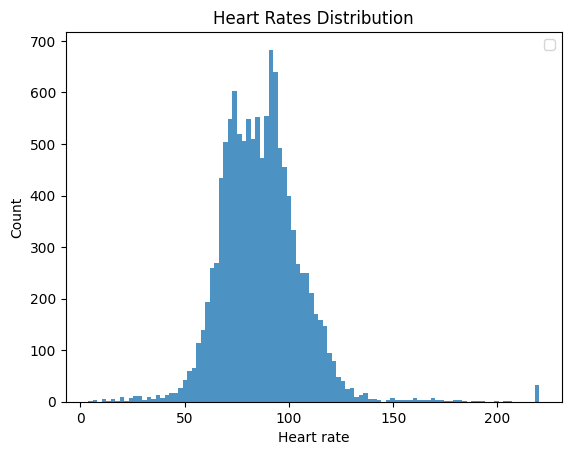

In [47]:
plt.hist(heart_rates_ecg, bins=100, alpha=0.8)

plt.title('Heart Rates Distribution')
plt.xlabel('Heart rate')
plt.ylabel('Count')
plt.legend()

# Heart Rate Variability (HRV) 

(array([1.1283e+04, 2.9600e+02, 1.3000e+02, 7.4000e+01, 4.9000e+01,
        3.7000e+01, 2.2000e+01, 1.9000e+01, 2.0000e+01, 7.0000e+00,
        5.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

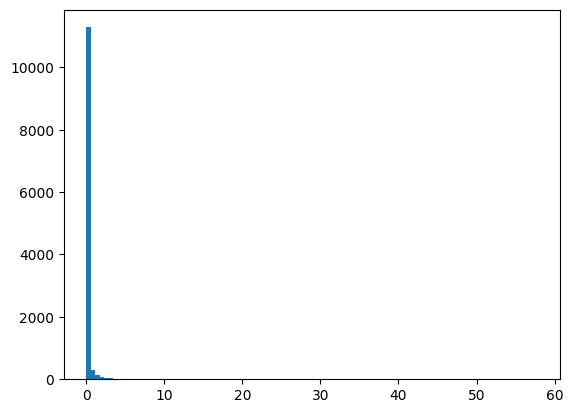

In [48]:
plt.hist(rr_interval_variability, bins= 100)